rough sketch: at 12 FPS, get the amplitude, and generate image.

In [1]:
import pydub
from pydub.utils import get_array_type
import numpy as np
import array
import matplotlib.pyplot as plt

In [2]:
from pydub import AudioSegment
sound = AudioSegment.from_file("/home/eric/stable-diffusion-hackathon/fun-life-112188.mp3", format="mp3")    
peak_amplitude = sound.max

In [3]:
sound.frame_rate

44100

In [4]:
left = sound.split_to_mono()[0]

bit_depth = left.sample_width * 8
array_type = get_array_type(bit_depth)

numeric_array = array.array(array_type, left._data)

In [5]:
# total seconds in the array
len(numeric_array) / sound.frame_rate

109.92326530612245

In [6]:
type(numeric_array)

array.array

In [7]:
sample_period = int(0.1 * sound.frame_rate) # 1 second
seconds = np.arange(0, len(numeric_array), sample_period) / sound.frame_rate

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

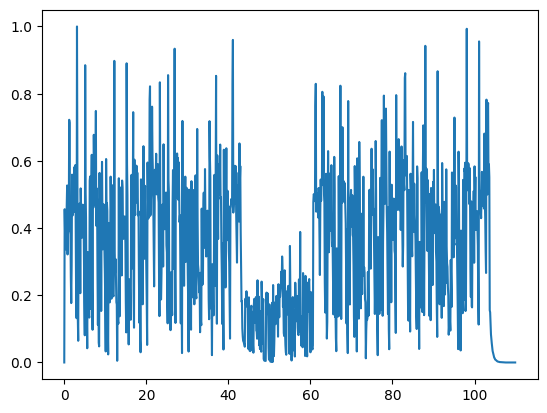

In [34]:
amplitudes = np.clip(2*moving_average(np.abs(numeric_array) / peak_amplitude, 1000), 0., 1.0)
# 0.05, 1.0)
amplitudes = amplitudes[::sample_period]
plt.plot(seconds, amplitudes)

In [35]:
import glob

Idea 1: sort amplitudes by strength, and then generate in batch corresponding to that strength, then stitch together videos in order.

In [36]:
interval = 0.05
strengths = np.arange(0.0, 1.0, interval)
strengths = [f'{s:.2f}' for s in strengths]

In [37]:
strengths

['0.00',
 '0.05',
 '0.10',
 '0.15',
 '0.20',
 '0.25',
 '0.30',
 '0.35',
 '0.40',
 '0.45',
 '0.50',
 '0.55',
 '0.60',
 '0.65',
 '0.70',
 '0.75',
 '0.80',
 '0.85',
 '0.90',
 '0.95']

In [38]:
counts = {s: 0 for s in strengths}

In [39]:
filenames = {s: glob.glob(f'/home/eric/repos/stable-diffusion/outputs/img2img-samples-{s}/*/*.png') for s in strengths}

In [40]:
# Starter image
filenames['0.00'].append("/home/eric/repos/stable-diffusion/outputs/txt2img-samples/Portrait_of_a_geometric_wolf,_identical_eyes,_medium_shot,_illustration,_symmetrical,_art_stand,_super_detailed,_cinematic_lig/seed_27_00000.png")

In [41]:

num_repeat = 0

out_names = []
for a in amplitudes:
    bucket = (a // interval) * interval
    
    # new file
    bucket = f'{bucket:.2f}'
    idx = counts[bucket]
    num_items = len(filenames[bucket])
    # print(a)
    assert num_items > 0
    fname = filenames[bucket][idx % num_items]
    counts[bucket] += 1 # increment to the next one
    
    out_names.append(fname)
    # print(fname)

In [42]:
for k, v in filenames.items():
    print(k, len(v))

0.00 19
0.05 8
0.10 18
0.15 18
0.20 18
0.25 18
0.30 18
0.35 18
0.40 18
0.45 18
0.50 18
0.55 18
0.60 18
0.65 18
0.70 18
0.75 18
0.80 18
0.85 18
0.90 18
0.95 18


In [43]:
with open('img_names.txt', 'w') as f:
    for l in out_names:
        f.write(f'file {l} \n')

ffmpeg -r 10 -f concat -safe 0 -i img_names.txt -c:v libx264 -crf 23 video.mp4

ffmpeg -i video.mp4 -i ~/stable-diffusion-hackathon/fun-life-112188.mp3 -map 0:v -map 1:a -c:v copy -shortest output.mp4